# Analysis of personal electric consumption
Electricty our sole source of power, including heating. The goal is to anlyze daily and monthly consumption to determine key factors of power consumption and evaluate the cost effectiveness and ROI of potential upgrades.

Hourly power consumption is provided by Hydro-Quebec at bi-monthly intervals as .csv files, including kWh and daily average temperature. Those files are downloaded locally to their own subdirectory (/data). This script will then join, extract, and analyze the data.

List of dependencies:

*listdir* from *os* - needed to read the filenames in the raw data directory

*pandas* - needed for data handling and processing

*seaborn* - preferred for plotting as it requires less coding than matplotlib, but still depends on matplot so not necessary

*matplotlib* - seaborn depends on matplotlib




## 0 User-defined valiables

In [1]:
rawDataPath = '/home/device/Documents/Hydro/rawData/' # directory with individual csv files from the utility
resultsDataPath = '/home/device/Documents/Hydro/processedData/'      # directory to contain the combined and processed data
headerRow = 'Contract;Date and time;kWh;Consumption code;Average temperature (C);Temperature code' #csv file headers
rawDataName = 'totalData.csv'                   # name of .csv file of the joined consumption data
processedDataName = 'elecData.csv'              # name of .csv file of the processed and cleaned consumption data
lowRate = 0.06319                               # Low rate charged at 6.319 cents/kWh
highRate = 0.09749                              # Low rate charged at 9.749 cents/kWh
connectionFee = 0.42238                         # Connection fee of 42.238 cents/day

## 1 Join data from bi-monthly sets into one large set

In [2]:
from os import listdir
import os

# Remove files covering duplicate periods with fewer days

file_prefixes = {} # dictionary to store file prefixes and their occurrences

# If two data files with the same start date exist, use only the file with more data
for file_name in os.listdir(rawDataPath):
    prefix = file_name[:26] # check the first characters of the file name
    file_path = os.path.join(rawDataPath, file_name)
    file_size = os.path.getsize(file_path)
    if prefix in file_prefixes:
        file1_path = file_prefixes[prefix]['path'] # replace with the actual path to the first file
        file2_path = file_path # replace with the actual path to the second file
        if file_size < file_prefixes[prefix]['size']:
            os.remove(file_prefixes[prefix]['path'])
            file_prefixes[prefix] = {'path': file_path, 'size': file_size}
            print(file2_path)
        else:
            os.remove(file1_path)

    else:
        file_prefixes[prefix] = {'path': file_path, 'size': file_size}


# List and store the .csv filenames in the rawDataPath to join in the next section
files =[]

for f in listdir(rawDataPath):
    if f.endswith('.csv'):
        files.append(f)


# Define where the combined data will live
filePath = resultsDataPath + rawDataName

#Open the new csv file to contain the combined data
newFile = open(filePath, 'w', encoding = 'UTF-8')

# Define the header row
newFile.write(f'{headerRow} \n')

# Join the data into one csv file
for file in files:
    openFile = open(rawDataPath + file, 'r', encoding = 'iso-8859-1')
    next(openFile)
    for line in openFile:
        newFile.write(line)


# Clear out unused variables - remove this line for troubleshooting or traceability
del f, file, files, line, newFile, openFile, rawDataPath, rawDataName, headerRow, file_name, file_prefixes, prefix, file_path, file_size

## 2 Convert to DataFrame and start processing
This will result in a N x 13 dataframe *elecData* with a line for each hour of consumption:

[Date and time, kWh, Average temperature (C), Date, Time, Year, Month, Day, Heat year, cum_daily, cum_monthly, Rate, Cost]

In [3]:
import pandas as pd

# Convert the combined csv to a dataframe (df)
elecData = pd.read_csv(filePath, sep=';')


# Split out the Date and time into their own columns while retaining the original 'Date and Time' column
elecData[['Date','Time']] = elecData['Date and time'].str.split(' ',n = 1, expand = True)


# Convert the original Date and time and new Date column to the pandas datetime format
elecData['Date and time'] = pd.to_datetime(elecData['Date and time'])
elecData['Date'] = pd.to_datetime(elecData['Date'])
elecData['Date'] = elecData['Date'].dt.date


# Isolate the year, month and day from the new Date column into seperate columns
elecData['Year'] = elecData['Date and time'].dt.year
elecData['Month'] = elecData['Date and time'].dt.month
elecData['Day'] = elecData['Date and time'].dt.day


# Define a 'Heat year' (analagous to a 'financial year') as starting from Sept 1 to compare annual heating data
elecData['Heat year'] = elecData['Date and time'].dt.to_period('Q-AUG').dt.qyear


# Add columns for running cumulative power used daily and monthly
elecData = elecData.sort_values(['Date and time']).reset_index(drop=True)
elecData['cum_daily'] = elecData.groupby(['Date'])['kWh'].cumsum()
elecData['cum_monthly'] = elecData.groupby(['Year','Month'])['kWh'].cumsum()


# Add a column for low or high rate based on a monthly cumulative threshold exceeding 40 kWh/day.
# Calculate the threshold for each month (40 kwH * # of days in month)
# Determine when the threshold is met and define the high/low rate
elecData['rate_thresh'] = 40*elecData['Date and time'].dt.days_in_month
elecData['Rate'] = 'high'
elecData.loc[elecData['cum_monthly'] < elecData['rate_thresh'], 'Rate'] = 'low'

# Calculate the pre-tax cost for power at each hour
elecData.loc[elecData['Rate'] == 'high', 'Cost'] = (elecData['kWh'] * highRate).round(2)
elecData.loc[elecData['Rate'] == 'low', 'Cost'] = (elecData['kWh'] * lowRate).round(2)

# Calculate the daily cumulative cost per month
elecData['cum_monthly_cost'] = elecData.groupby(['Year','Month'])['Cost'].cumsum()

# Drop the Contract number, Consumption code, and Temperature code
elecData = elecData.drop(['Contract', 'Consumption code', 'Temperature code ', 'rate_thresh'], axis = 1)


#Save the dataframe to a new csv file
elecData.to_csv(resultsDataPath + processedDataName, sep=';', encoding='UTF-8')

# Clear out unused non-data variables - comment out for troubleshooting or traceability
#del processedDataName, filePath

## 3 Check consumption by day

### 3.0.a Sum daily consumption to visualize impact of temperature on energy useage

In [4]:
#Calculate the cumulative consumption and cost per day and place in a new DF
dailyDF = pd.DataFrame()

dailyDF['kWh day'] = elecData.groupby(['Date'])['kWh'].sum()
dailyDF['Avg. Temp'] = elecData.groupby(['Date'])['Average temperature (C)'].mean()
dailyDF['Cost'] = elecData.groupby(['Date'])['Cost'].sum()
dailyDF['Heat Year'] = elecData.groupby(['Date'])['Heat year'].unique()
dailyDF['Rate'] = elecData.groupby(['Date'])['Rate'].last()

# Get the hourly consumption per day
dates = elecData['Date']
hours = elecData['Time'].unique()


hourly_ = []

for date in dates:
    d = elecData[elecData['Date'] == date]['kWh'].tolist()
    hourly_.append(d)


hourly_df = pd.DataFrame(hourly_, index=dates).transpose()


### 3.0.b Determine the monthly date where the high rate is charged

In [5]:
months = elecData['Month'].unique()
years = elecData['Heat year'].unique()


# Prep a list to hold Year, Month, First High Date
firstHigh = []


for year in years:
    
    y = elecData[(elecData['Heat year'] == year)]

    for month in months:

        # Find the date at which the high rate applies

        rate_check = y[(elecData['Rate'] == 'high')]

        m = rate_check[rate_check['Month'] == month].iloc[::-1]
        
        if m.empty:
            pass
        
        else:
            rateDF = m['Rate']
            firstIndex = rateDF.first_valid_index()
            firstDate = m['Day'][firstIndex]            
            firstHigh.append((year, month, firstDate))

firstHighDF = pd.DataFrame(firstHigh, columns = ['Heat year', 'Month', 'First high rate'])
    

/tmp/ipykernel_10147/3014691123.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rate_check = y[(elecData['Rate'] == 'high')]


## 3.1 Generate daily consumption plots

### 3.1.a *Heatmap* : Hous vs. Date, hue = Consumption -> colorful visual showing daily consumption by hour

Text(0.5, 1.0, 'Hourly consumption by day')

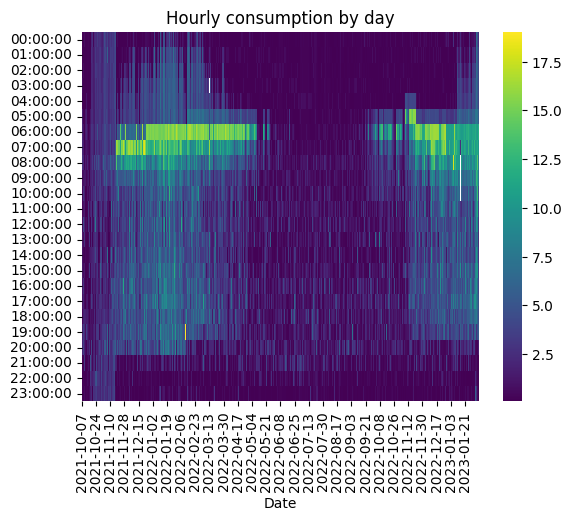

In [6]:
# heatmap with Seaborn
import seaborn as sns

sns.heatmap(hourly_df, cmap='viridis', linewidths=0, annot=False, yticklabels=hours).set_title('Hourly consumption by day')


### 3.1.b Scatterplots: Temperature, Consumption and Cost

*Scatterplot* : kWh vs. Date, hue = Temp. -> shows timeseries of daily consumption and the impact of temperature

*Scatterplot* : kWh vs. Temp., hue = Heat year -> shows energy consumption as a f'n of temp., with each heat year as a series

*Scatterplot with regression* : Cost vs. Temperature for heat days


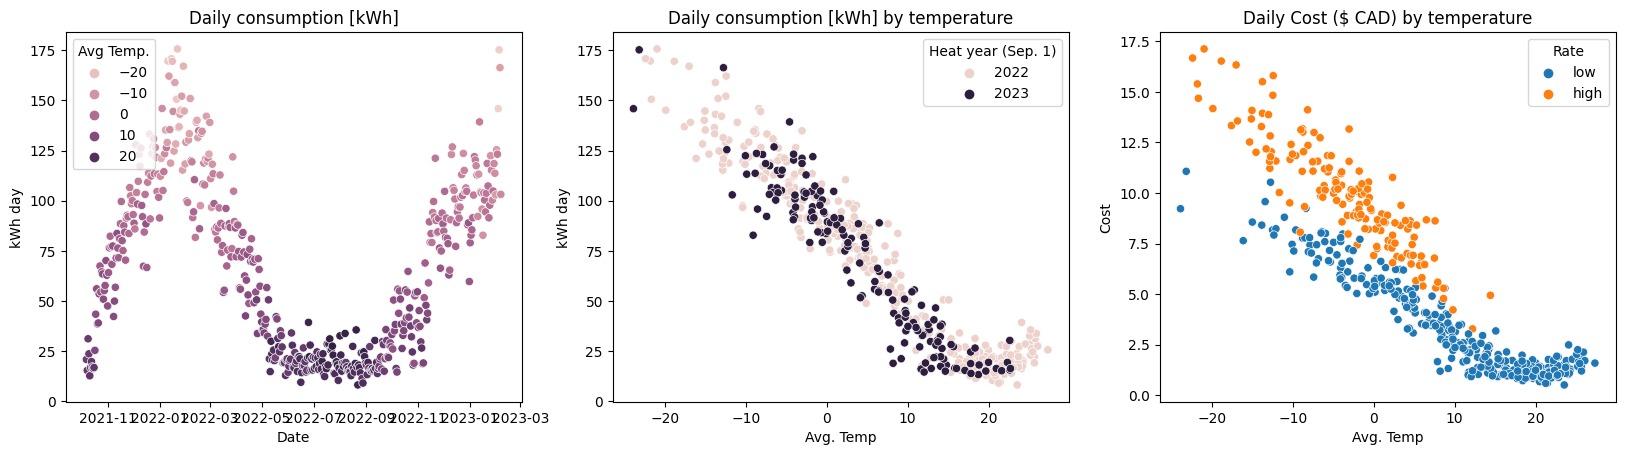

In [7]:
# import seaborn as sns (imported above)
import matplotlib.pyplot as plt

f, axes = plt.subplots(ncols=3, figsize=[20, 4.8])

sns.scatterplot(x=dailyDF.index, y=dailyDF['kWh day'], hue=dailyDF['Avg. Temp'], ax=axes[0]).set_title('Daily consumption [kWh]')
sns.scatterplot(x=dailyDF['Avg. Temp'], y=dailyDF['kWh day'], hue=dailyDF['Heat Year'].astype(int), ax=axes[1]).set_title('Daily consumption [kWh] by temperature')
sns.scatterplot(x=dailyDF['Avg. Temp'], y=dailyDF['Cost'], hue=dailyDF['Rate'], ax=axes[2]).set_title('Daily Cost ($ CAD) by temperature')

axes[0].legend(loc='upper left').set_title('Avg Temp.')
axes[1].legend().set_title('Heat year (Sep. 1)')


## 4 Determine cost of heating
- Determine baseline power consumption - assume days with avg. temp between 18-23
- Assume days under 12 oC require heating
- Run linear regression on kWh vs. T

### 4.0.a Determine baseline, and cost of heating

In [8]:
# Calculate heating by  hourly data

# Use two methods: sum of the mean hourly vs. mean daily; compare to the stdev of both
# Estimate a baseline consumption per hour for non-heating days. Assume 19-21 oC need to no heating or AC
heatBaseline = pd.DataFrame()
heatBaselineDays = elecData.loc[(elecData['Average temperature (C)'] > 18) & (elecData['Average temperature (C)'] < 22)]
heatBaseline['kWh_baseline'] = heatBaselineDays.groupby(['Time'])['kWh'].mean()
heatBaseline['Stdev_baseline'] = heatBaselineDays.groupby(['Time'])['kWh'].std()


# Sum the hourly baseline consumption for a daily baseline
heatBaselineSum = heatBaseline['kWh_baseline'].sum()
heatBaselineStd = heatBaseline['kWh_baseline'].std()
print(heatBaselineSum, heatBaselineStd)

# Second method - take the average of daily consumption for non-heating days
baselineTest = dailyDF.loc[(dailyDF['Avg. Temp'] > 18) & (dailyDF['Avg. Temp'] < 22)]
baselineDailySum = baselineTest['kWh day'].mean()
baselineDailySumStd = baselineTest['kWh day'].std()
print(baselineDailySum, baselineDailySumStd)

# Subtract the value from total hourly consumption. Define average T below 13 oC as requiring heating

heatDays = elecData.loc[(elecData['Average temperature (C)'] < 13)]

heatDays = heatDays.merge(heatBaseline, left_on='Time', right_on='Time')
heatDays['kWh_heating'] = heatDays['kWh'].subtract(heatDays['kWh_baseline'])
heatDays.loc[(heatDays['kWh_heating'] < 0), 'kWh_heating'] = 0

19.29900658149558 0.45326099897099426
17.983174603174604 4.667135899165577
